# Uber Traffic Data Analysis

This notebook performs comprehensive data processing on the Uber Traffic dataset including:
1. Loading raw data into pandas DataFrames
2. Data cleaning (missing values, duplicates, data types)
3. Aggregating traffic data into hourly intervals
4. Data preprocessing and normalization

## Dataset Overview
- **File**: Dataset_Uber Traffic.csv
- **Columns**: DateTime, Junction, Vehicles, ID
- **Time Period**: 2015-2017
- **Data Frequency**: Hourly intervals
- **Junctions**: 4 different traffic junctions


In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load Raw Data

Reading the collected data into pandas DataFrames.


In [18]:
file_path = 'Dataset_Uber Traffic.csv'

try:
    df = pd.read_csv(file_path)
    print("✅ Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")    

    print("\nDataset Overview:")
    print(df.head(10))
    
    print("\nDataset Info:")
    print(df.info())
    
    print("\nBasic Statistics:")
    print(df.describe())
    
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found!")
except Exception as e:
    print(f"Error loading data: {str(e)}")


✅ Data loaded successfully!
Dataset shape: (48120, 4)

Dataset Overview:
        DateTime  Junction  Vehicles           ID
0  01/11/15 0:00         1        15  20151101001
1  01/11/15 1:00         1        13  20151101011
2  01/11/15 2:00         1        10  20151101021
3  01/11/15 3:00         1         7  20151101031
4  01/11/15 4:00         1         9  20151101041
5  01/11/15 5:00         1         6  20151101051
6  01/11/15 6:00         1         9  20151101061
7  01/11/15 7:00         1         8  20151101071
8  01/11/15 8:00         1        11  20151101081
9  01/11/15 9:00         1        12  20151101091

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1

## 2. Clean Data

Handling missing values, removing duplicates, and correcting data types.


In [19]:
# Create a copy of the original data for cleaning
df_clean = df.copy()

print("🔍 Data Quality Assessment:")
print("=" * 50)

# Checking for missing values
print("1. Missing Values Analysis:")
missing_values = df_clean.isnull().sum()
missing_percentage = (missing_values / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing Percentage': missing_percentage.values
})
print(missing_df)

# Checking for duplicates
print(f"\n2. Duplicate Records:")
duplicate_count = df_clean.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")
print(f"Percentage of duplicates: {(duplicate_count / len(df_clean)) * 100:.2f}%")

# Checking the data types
print(f"\n3. Current Data Types:")
print(df_clean.dtypes)

# Checking for any obvious data quality issues
print(f"\n4. Data Quality Issues:")
print(f"Negative vehicle counts: {(df_clean['Vehicles'] < 0).sum()}")
print(f"Zero vehicle counts: {(df_clean['Vehicles'] == 0).sum()}")
print(f"Unique junctions: {df_clean['Junction'].nunique()}")
print(f"Junction values: {sorted(df_clean['Junction'].unique())}")


🔍 Data Quality Assessment:
1. Missing Values Analysis:
     Column  Missing Count  Missing Percentage
0  DateTime              0                 0.0
1  Junction              0                 0.0
2  Vehicles              0                 0.0
3        ID              0                 0.0

2. Duplicate Records:
Total duplicate rows: 0
Percentage of duplicates: 0.00%

3. Current Data Types:
DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

4. Data Quality Issues:
Negative vehicle counts: 0
Zero vehicle counts: 0
Unique junctions: 4
Junction values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [20]:
# Data Cleaning Operations
print("Performing Data Cleaning:")
print("=" * 50)

# 1. Handle missing values
print("1. Handling Missing Values:")
if df_clean.isnull().sum().sum() > 0:
    # For missing values in Vehicles column, use median by junction
    if df_clean['Vehicles'].isnull().sum() > 0:
        median_by_junction = df_clean.groupby('Junction')['Vehicles'].median()
        df_clean['Vehicles'] = df_clean.apply(
            lambda row: median_by_junction[row['Junction']] if pd.isnull(row['Vehicles']) else row['Vehicles'], 
            axis=1
        )
        print(f"   - Filled {df_clean['Vehicles'].isnull().sum()} missing vehicle counts with median by junction")
    
    # For other missing values, use appropriate methods
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')
    print(f"   - Forward/backward filled remaining missing values")
else:
    print("   - No missing values found")

# Remove duplicates
print("\n2. Removing Duplicates:")
initial_count = len(df_clean)
df_clean = df_clean.drop_duplicates()
final_count = len(df_clean)
removed_duplicates = initial_count - final_count
print(f"   - Removed {removed_duplicates} duplicate records")
print(f"   - Dataset size: {initial_count} → {final_count}")

# Correct data types
print("\n3. Correcting Data Types:")
print("   Before conversion:")
print(f"   - DateTime: {df_clean['DateTime'].dtype}")
print(f"   - Junction: {df_clean['Junction'].dtype}")
print(f"   - Vehicles: {df_clean['Vehicles'].dtype}")
print(f"   - ID: {df_clean['ID'].dtype}")

# Convert DateTime to proper datetime format
df_clean['DateTime'] = pd.to_datetime(df_clean['DateTime'], format='%d/%m/%y %H:%M')

# Convert Junction to categorical for better memory usage
df_clean['Junction'] = df_clean['Junction'].astype('category')

# Ensure Vehicles is integer
df_clean['Vehicles'] = df_clean['Vehicles'].astype('int64')

# Convert ID to string to preserve leading zeros if any
df_clean['ID'] = df_clean['ID'].astype('str')

print("\n   After conversion:")
print(f"   - DateTime: {df_clean['DateTime'].dtype}")
print(f"   - Junction: {df_clean['Junction'].dtype}")
print(f"   - Vehicles: {df_clean['Vehicles'].dtype}")
print(f"   - ID: {df_clean['ID'].dtype}")

# 4. Add derived columns for better analysis
print("\n4. Adding Derived Columns:")
df_clean['Year'] = df_clean['DateTime'].dt.year
df_clean['Month'] = df_clean['DateTime'].dt.month
df_clean['Day'] = df_clean['DateTime'].dt.day
df_clean['Hour'] = df_clean['DateTime'].dt.hour
df_clean['DayOfWeek'] = df_clean['DateTime'].dt.dayofweek
df_clean['DayName'] = df_clean['DateTime'].dt.day_name()
df_clean['Weekend'] = df_clean['DayOfWeek'].isin([5, 6])

print("   - Added: Year, Month, Day, Hour, DayOfWeek, DayName, Weekend")

print(f"\nData cleaning completed!")
print(f"Final dataset shape: {df_clean.shape}")
print(f"Memory usage after cleaning: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Performing Data Cleaning:
1. Handling Missing Values:
   - No missing values found

2. Removing Duplicates:
   - Removed 0 duplicate records
   - Dataset size: 48120 → 48120

3. Correcting Data Types:
   Before conversion:
   - DateTime: object
   - Junction: int64
   - Vehicles: int64
   - ID: int64

   After conversion:
   - DateTime: datetime64[ns]
   - Junction: category
   - Vehicles: int64
   - ID: object

4. Adding Derived Columns:
   - Added: Year, Month, Day, Hour, DayOfWeek, DayName, Weekend

Data cleaning completed!
Final dataset shape: (48120, 11)
Memory usage after cleaning: 7.07 MB


## 3. Aggregate Traffic Data

Compiling traffic data into hourly intervals for each junction with relevant details such as vehicle counts.


In [21]:
# Data Aggregation Analysis
print("Traffic Data Aggregation:")
print("=" * 50)

# Since the data is already in hourly intervals, let's verify and create comprehensive aggregations
print("1. Current Data Structure Analysis:")
print(f"   - Total records: {len(df_clean):,}")
print(f"   - Date range: {df_clean['DateTime'].min()} to {df_clean['DateTime'].max()}")
print(f"   - Number of junctions: {df_clean['Junction'].nunique()}")
print(f"   - Hours per day: {df_clean['Hour'].nunique()}")
print(f"   - Total days covered: {df_clean['DateTime'].dt.date.nunique()}")

# Check if data is already properly aggregated by hour
print(f"\n2. Hourly Aggregation Verification:")
hourly_counts = df_clean.groupby(['DateTime', 'Junction']).size()
duplicate_hours = (hourly_counts > 1).sum()
print(f"   - Records with same DateTime and Junction: {duplicate_hours}")
if duplicate_hours == 0:
    print("    Data is already properly aggregated by hour")
else:
    print("     Data needs aggregation - multiple records per hour found")

# Create comprehensive hourly aggregations
print(f"\n3. Creating Comprehensive Hourly Aggregations:")

# Group by DateTime and Junction to ensure proper hourly aggregation
df_hourly = df_clean.groupby(['DateTime', 'Junction']).agg({
    'Vehicles': ['sum', 'mean', 'std', 'min', 'max', 'count'],
    'Year': 'first',
    'Month': 'first', 
    'Day': 'first',
    'Hour': 'first',
    'DayOfWeek': 'first',
    'DayName': 'first',
    'Weekend': 'first'
}).reset_index()

# Flatten column names
df_hourly.columns = ['DateTime', 'Junction', 'Vehicles_Sum', 'Vehicles_Mean', 'Vehicles_Std', 
                    'Vehicles_Min', 'Vehicles_Max', 'Vehicles_Count', 'Year', 'Month', 'Day', 
                    'Hour', 'DayOfWeek', 'DayName', 'Weekend']

# Round numeric columns
df_hourly['Vehicles_Mean'] = df_hourly['Vehicles_Mean'].round(2)
df_hourly['Vehicles_Std'] = df_hourly['Vehicles_Std'].round(2)

print(f"   - Created hourly aggregation with {len(df_hourly):,} records")
print(f"   - Added statistics: Sum, Mean, Std, Min, Max, Count")

# Display sample of aggregated data
print(f"\n4. Sample of Aggregated Data:")
print(df_hourly.head(10))


Traffic Data Aggregation:
1. Current Data Structure Analysis:
   - Total records: 48,120
   - Date range: 2015-11-01 00:00:00 to 2017-06-30 23:00:00
   - Number of junctions: 4
   - Hours per day: 24
   - Total days covered: 608

2. Hourly Aggregation Verification:
   - Records with same DateTime and Junction: 0
    Data is already properly aggregated by hour

3. Creating Comprehensive Hourly Aggregations:
   - Created hourly aggregation with 58,368 records
   - Added statistics: Sum, Mean, Std, Min, Max, Count

4. Sample of Aggregated Data:
             DateTime Junction  Vehicles_Sum  Vehicles_Mean  Vehicles_Std  \
0 2015-11-01 00:00:00        1            15           15.0           NaN   
1 2015-11-01 00:00:00        2             6            6.0           NaN   
2 2015-11-01 00:00:00        3             9            9.0           NaN   
3 2015-11-01 00:00:00        4             0            NaN           NaN   
4 2015-11-01 01:00:00        1            13           13.0        

In [22]:
# Additional Aggregations for Analysis
print("5. Creating Additional Time-based Aggregations:")

# Daily aggregations
df_daily = df_hourly.groupby(['Year', 'Month', 'Day', 'Junction']).agg({
    'Vehicles_Sum': ['sum', 'mean', 'std', 'min', 'max'],
    'Vehicles_Mean': 'mean',
    'Vehicles_Std': 'mean',
    'DayOfWeek': 'first',
    'DayName': 'first',
    'Weekend': 'first'
}).reset_index()

# Flatten column names for daily data
df_daily.columns = ['Year', 'Month', 'Day', 'Junction', 'Daily_Total', 'Daily_Mean', 
                   'Daily_Std', 'Daily_Min', 'Daily_Max', 'Hourly_Mean_Avg', 
                   'Hourly_Std_Avg', 'DayOfWeek', 'DayName', 'Weekend']

# Round numeric columns
numeric_cols = ['Daily_Mean', 'Daily_Std', 'Hourly_Mean_Avg', 'Hourly_Std_Avg']
for col in numeric_cols:
    df_daily[col] = df_daily[col].round(2)

# Monthly aggregations
df_monthly = df_hourly.groupby(['Year', 'Month', 'Junction']).agg({
    'Vehicles_Sum': ['sum', 'mean', 'std', 'min', 'max'],
    'Vehicles_Mean': 'mean',
    'Vehicles_Std': 'mean'
}).reset_index()

# Flatten column names for monthly data
df_monthly.columns = ['Year', 'Month', 'Junction', 'Monthly_Total', 'Monthly_Mean', 
                     'Monthly_Std', 'Monthly_Min', 'Monthly_Max', 'Hourly_Mean_Avg', 
                     'Hourly_Std_Avg']

# Round numeric columns
numeric_cols = ['Monthly_Mean', 'Monthly_Std', 'Hourly_Mean_Avg', 'Hourly_Std_Avg']
for col in numeric_cols:
    df_monthly[col] = df_monthly[col].round(2)

print(f"   - Daily aggregations: {len(df_daily):,} records")
print(f"   - Monthly aggregations: {len(df_monthly):,} records")

# Summary statistics by junction
print(f"\n6. Summary Statistics by Junction:")
junction_stats = df_hourly.groupby('Junction')['Vehicles_Sum'].agg([
    'count', 'sum', 'mean', 'std', 'min', 'max'
]).round(2)
junction_stats.columns = ['Records', 'Total_Vehicles', 'Avg_Vehicles', 'Std_Vehicles', 'Min_Vehicles', 'Max_Vehicles']
print(junction_stats)

print(f"\n✅ Data aggregation completed!")
print(f"   - Hourly data: {len(df_hourly):,} records")
print(f"   - Daily data: {len(df_daily):,} records") 
print(f"   - Monthly data: {len(df_monthly):,} records")


5. Creating Additional Time-based Aggregations:
   - Daily aggregations: 4,464 records
   - Monthly aggregations: 144 records

6. Summary Statistics by Junction:
          Records  Total_Vehicles  Avg_Vehicles  Std_Vehicles  Min_Vehicles  \
Junction                                                                      
1           14592          657412         45.05         23.01             5   
2           14592          207983         14.25          7.40             1   
3           14592          199823         13.69         10.44             1   
4           14592           31501          2.16          3.83             0   

          Max_Vehicles  
Junction                
1                  156  
2                   48  
3                  180  
4                   36  

✅ Data aggregation completed!
   - Hourly data: 58,368 records
   - Daily data: 4,464 records
   - Monthly data: 144 records


## 4. Preprocess Data

Normalizing and standardizing the data to facilitate comparison across different time periods and junctions.


In [23]:
# Data Preprocessing and Normalization
print("📊 Data Preprocessing and Normalization:")
print("=" * 40)

# Create a copy for preprocessing
df_processed = df_hourly.copy()

print("1. Statistical Analysis Before Normalization:")
print("   Vehicle Count Statistics by Junction:")
for junction in sorted(df_processed['Junction'].unique()):
    junction_data = df_processed[df_processed['Junction'] == junction]['Vehicles_Sum']
    print(f"   Junction {junction}: Mean={junction_data.mean():.2f}, Std={junction_data.std():.2f}, "
          f"Min={junction_data.min()}, Max={junction_data.max()}")


📊 Data Preprocessing and Normalization:
1. Statistical Analysis Before Normalization:
   Vehicle Count Statistics by Junction:
   Junction 1: Mean=45.05, Std=23.01, Min=5, Max=156
   Junction 2: Mean=14.25, Std=7.40, Min=1, Max=48
   Junction 3: Mean=13.69, Std=10.44, Min=1, Max=180
   Junction 4: Mean=2.16, Std=3.83, Min=0, Max=36


In [24]:
# 2. Z-Score Standardization
print(f"\n2. Z-Score Standardization:")
from sklearn.preprocessing import StandardScaler

# Global z-score
scaler = StandardScaler()
df_processed['Vehicles_ZScore'] = scaler.fit_transform(df_processed[['Vehicles_Sum']])

# Junction-specific z-scores
print("   Creating junction-specific z-scores:")
for junction in sorted(df_processed['Junction'].unique()):
    junction_mask = df_processed['Junction'] == junction
    junction_scaler = StandardScaler()
    df_processed.loc[junction_mask, 'Vehicles_ZScore_ByJunction'] = junction_scaler.fit_transform(
        df_processed.loc[junction_mask, ['Vehicles_Sum']]
    )

# 3. Min-Max Normalization
print(f"\n3. Min-Max Normalization:")
from sklearn.preprocessing import MinMaxScaler

# Global min-max
minmax_scaler = MinMaxScaler()
df_processed['Vehicles_MinMax'] = minmax_scaler.fit_transform(df_processed[['Vehicles_Sum']])

# Junction-specific min-max
print("   Creating junction-specific min-max normalization:")
for junction in sorted(df_processed['Junction'].unique()):
    junction_mask = df_processed['Junction'] == junction
    junction_minmax = MinMaxScaler()
    df_processed.loc[junction_mask, 'Vehicles_MinMax_ByJunction'] = junction_minmax.fit_transform(
        df_processed.loc[junction_mask, ['Vehicles_Sum']]
    )

print("   Z-score and Min-Max normalization completed")



2. Z-Score Standardization:
   Creating junction-specific z-scores:

3. Min-Max Normalization:
   Creating junction-specific min-max normalization:
   Z-score and Min-Max normalization completed


In [25]:
# 4. Robust Scaling
print(f"\n4. Robust Scaling (median and IQR):")
from sklearn.preprocessing import RobustScaler

# Global robust scaling
robust_scaler = RobustScaler()
df_processed['Vehicles_Robust'] = robust_scaler.fit_transform(df_processed[['Vehicles_Sum']])

# Junction-specific robust scaling
print("   Creating junction-specific robust scaling:")
for junction in sorted(df_processed['Junction'].unique()):
    junction_mask = df_processed['Junction'] == junction
    junction_robust = RobustScaler()
    df_processed.loc[junction_mask, 'Vehicles_Robust_ByJunction'] = junction_robust.fit_transform(
        df_processed.loc[junction_mask, ['Vehicles_Sum']]
    )

print("   Robust scaling completed")

# Quick validation
print(f"\n✅ NORMALIZATION COMPLETE!")
print(f"   Original columns: {len(df_hourly.columns)}")
print(f"   New columns added: {len(df_processed.columns) - len(df_hourly.columns)}")
print(f"   Dataset shape: {df_processed.shape}")



4. Robust Scaling (median and IQR):
   Creating junction-specific robust scaling:
   Robust scaling completed

✅ NORMALIZATION COMPLETE!
   Original columns: 15
   New columns added: 6
   Dataset shape: (58368, 21)


In [26]:
# 5. Time-based Normalization - Data Validation
print(f"\n5. Time-based Normalization:")

# Check for NaN values in time columns
print("   Checking for missing values in time columns:")
print(f"   - Hour column NaN count: {df_processed['Hour'].isna().sum()}")
print(f"   - DayOfWeek column NaN count: {df_processed['DayOfWeek'].isna().sum()}")
print(f"   - Month column NaN count: {df_processed['Month'].isna().sum()}")

# Remove rows with NaN values in time columns for normalization
df_clean_time = df_processed.dropna(subset=['Hour', 'DayOfWeek', 'Month']).copy()
print(f"   - Rows after removing NaN time values: {len(df_clean_time)}")

# Initialize the normalization columns with NaN
df_processed['Vehicles_HourlyNorm'] = np.nan
df_processed['Vehicles_DayOfWeekNorm'] = np.nan
df_processed['Vehicles_MonthlyNorm'] = np.nan



5. Time-based Normalization:
   Checking for missing values in time columns:
   - Hour column NaN count: 10248
   - DayOfWeek column NaN count: 10248
   - Month column NaN count: 10248
   - Rows after removing NaN time values: 48120


In [27]:
# Apply hour, day-of-week, and monthly normalizations
def apply_time_normalization(df, clean_df, time_col, norm_col):
    means = clean_df.groupby(time_col)['Vehicles_Sum'].mean()
    stds = clean_df.groupby(time_col)['Vehicles_Sum'].std()
    
    valid_mask = df[time_col].notna()
    df.loc[valid_mask, norm_col] = df.loc[valid_mask].apply(
        lambda row: (row['Vehicles_Sum'] - means[row[time_col]]) / stds[row[time_col]] 
        if stds[row[time_col]] != 0 and not pd.isna(stds[row[time_col]]) else 0, axis=1
    )

print("   Creating hour-of-day normalization:")
apply_time_normalization(df_processed, df_clean_time, 'Hour', 'Vehicles_HourlyNorm')

print("   Creating day-of-week normalization:")
apply_time_normalization(df_processed, df_clean_time, 'DayOfWeek', 'Vehicles_DayOfWeekNorm')

print("   Creating monthly normalization:")
apply_time_normalization(df_processed, df_clean_time, 'Month', 'Vehicles_MonthlyNorm')

print("   Time-based normalization completed")


   Creating hour-of-day normalization:
   Creating day-of-week normalization:
   Creating monthly normalization:
   Time-based normalization completed


In [28]:
# 6. Create comparison metrics
print(f"\n6. Creating Comparison Metrics:")

# Traffic categories and classifications
df_processed['Traffic_Intensity'] = pd.cut(
    df_processed['Vehicles_Sum'], 
    bins=[0, 5, 10, 15, 20, float('inf')], 
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

df_processed['Peak_Hour'] = df_processed['Hour'].isin([7, 8, 9, 17, 18, 19])
df_processed['Rush_Hour'] = df_processed['Hour'].isin([7, 8, 9, 17, 18])
df_processed['Day_Type'] = df_processed['Weekend'].map({True: 'Weekend', False: 'Weekday'})

print("   Comparison metrics created")

# 7. Final Summary
print(f"\n📊 PREPROCESSING COMPLETE!")
print(f"   Original columns: {len(df_hourly.columns)}")
print(f"   Final columns: {len(df_processed.columns)}")
print(f"   Dataset shape: {df_processed.shape}")
print(f"   Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Quick sample view
sample_cols = ['DateTime', 'Junction', 'Vehicles_Sum', 'Vehicles_ZScore', 'Traffic_Intensity', 'Peak_Hour']
print(f"\n🔍 Sample Data:")
print(df_processed[sample_cols].head(5))



6. Creating Comparison Metrics:
   Comparison metrics created

📊 PREPROCESSING COMPLETE!
   Original columns: 15
   Final columns: 28
   Dataset shape: (58368, 28)
   Memory usage: 17.31 MB

🔍 Sample Data:
             DateTime Junction  Vehicles_Sum  Vehicles_ZScore  \
0 2015-11-01 00:00:00        1            15        -0.182725   
1 2015-11-01 00:00:00        2             6        -0.616668   
2 2015-11-01 00:00:00        3             9        -0.472020   
3 2015-11-01 00:00:00        4             0        -0.905963   
4 2015-11-01 01:00:00        1            13        -0.279157   

  Traffic_Intensity  Peak_Hour  
0            Medium      False  
1               Low      False  
2               Low      False  
3               NaN      False  
4            Medium      False  


## 5. Data Visualization and Analysis

Visualizing the processed data to understand traffic patterns and validate our preprocessing steps.


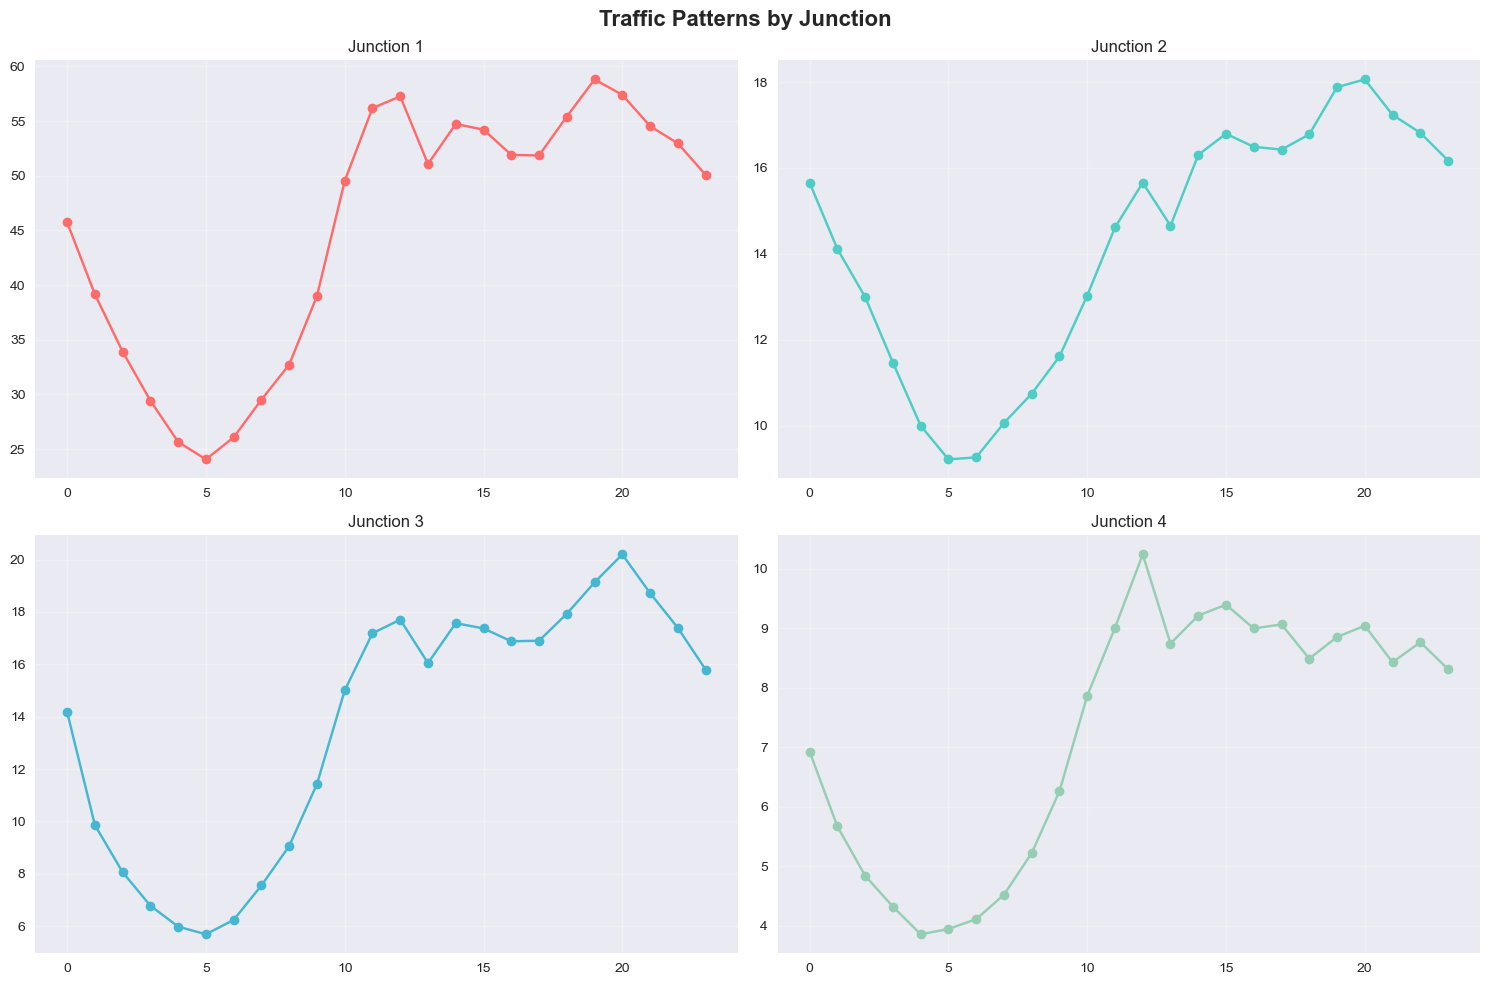

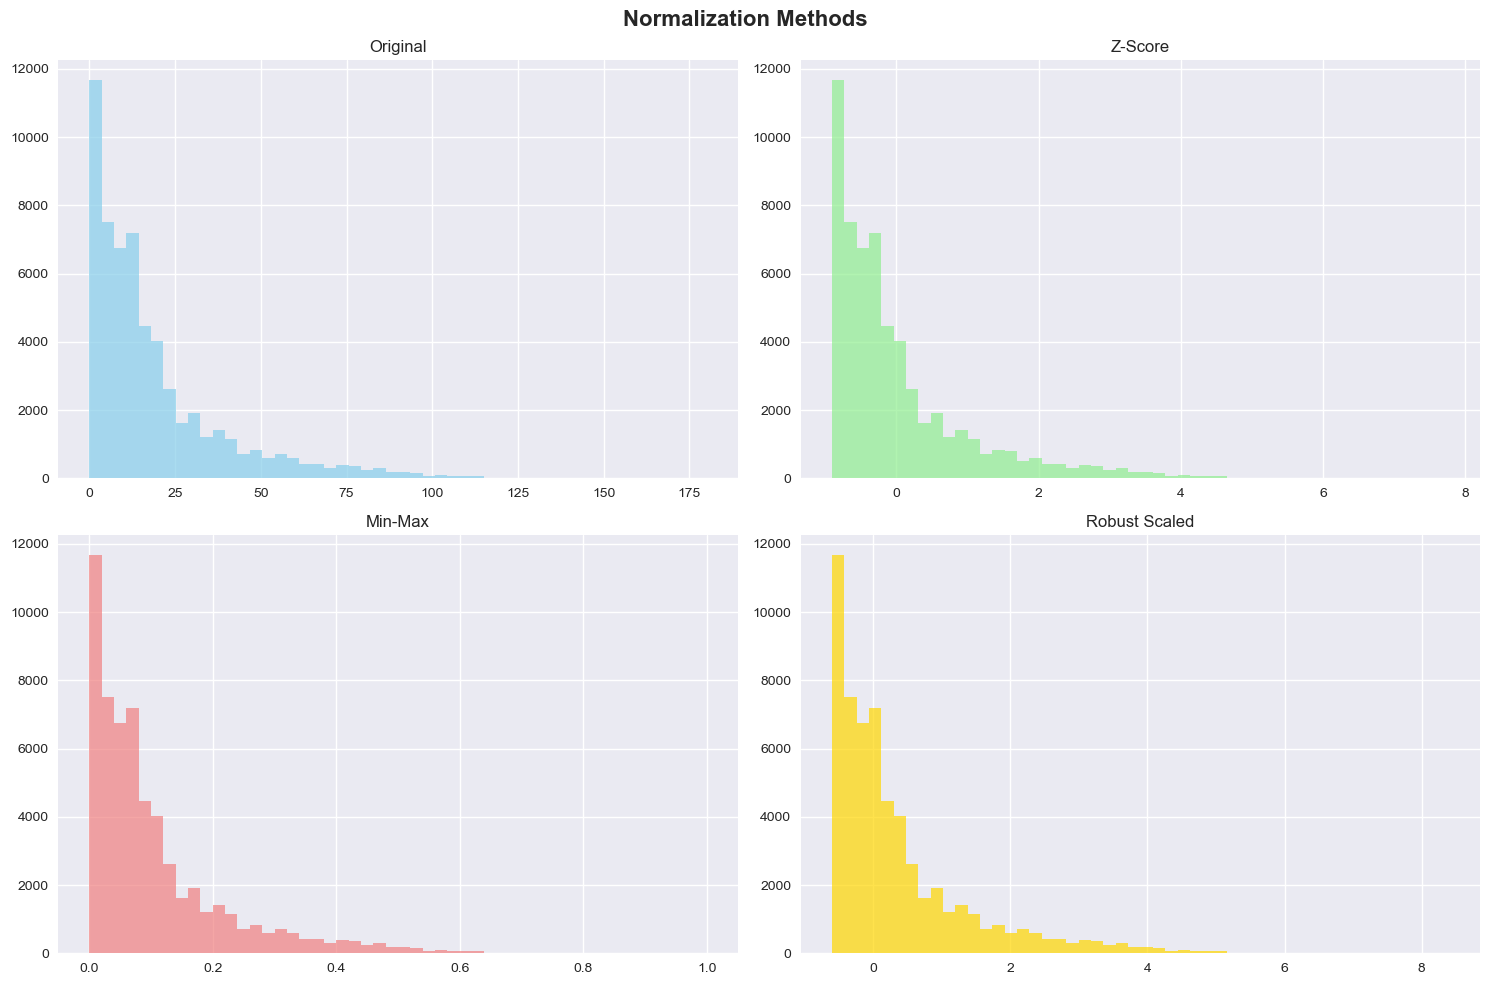

In [29]:
# Data Visualization
plt.style.use('seaborn-v0_8')
fig_size = (15, 10)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 1. Traffic by Junction
fig, axes = plt.subplots(2, 2, figsize=fig_size)
fig.suptitle('Traffic Patterns by Junction', fontsize=16, fontweight='bold')

for i, junction in enumerate(sorted(df_processed['Junction'].unique())):
    ax = axes[i//2, i%2]
    junction_data = df_processed[df_processed['Junction'] == junction]
    hourly_avg = junction_data.groupby('Hour')['Vehicles_Sum'].mean()
    
    ax.plot(hourly_avg.index, hourly_avg.values, 'o-', color=colors[i])
    ax.set_title(f'Junction {junction}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Normalization Comparison
fig, axes = plt.subplots(2, 2, figsize=fig_size)
fig.suptitle('Normalization Methods', fontsize=16, fontweight='bold')

# Plot distributions
data_cols = ['Vehicles_Sum', 'Vehicles_ZScore', 'Vehicles_MinMax', 'Vehicles_Robust']
titles = ['Original', 'Z-Score', 'Min-Max', 'Robust Scaled']
hist_colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

for i, (col, title, color) in enumerate(zip(data_cols, titles, hist_colors)):
    ax = axes[i//2, i%2]
    ax.hist(df_processed[col], bins=50, alpha=0.7, color=color)
    ax.set_title(title)

plt.tight_layout()
plt.show()


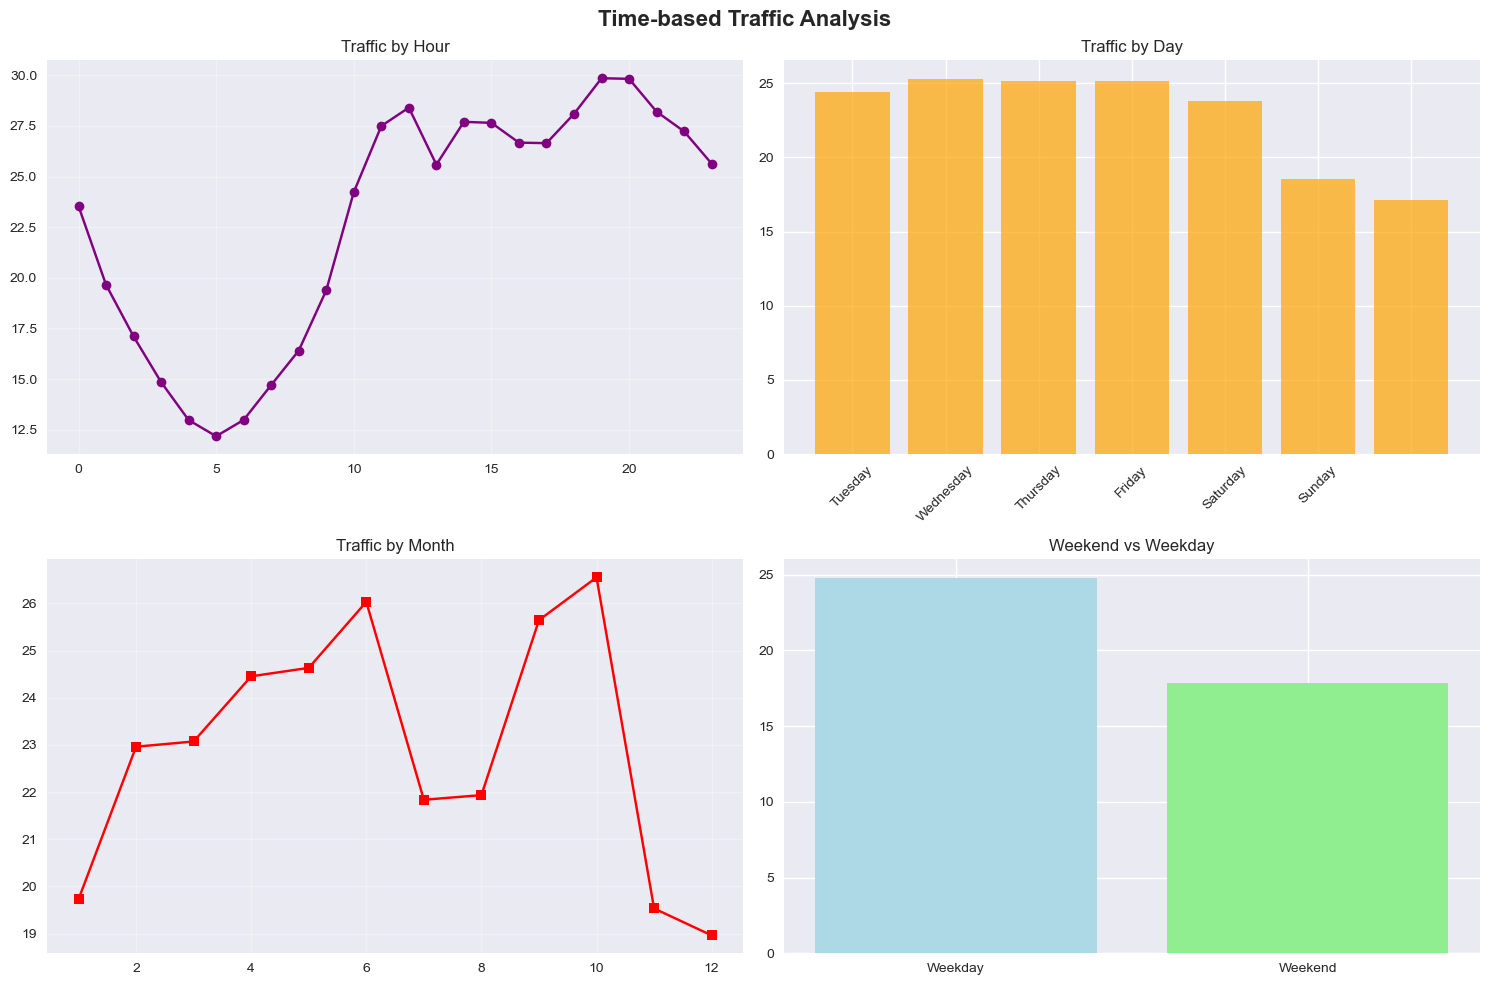

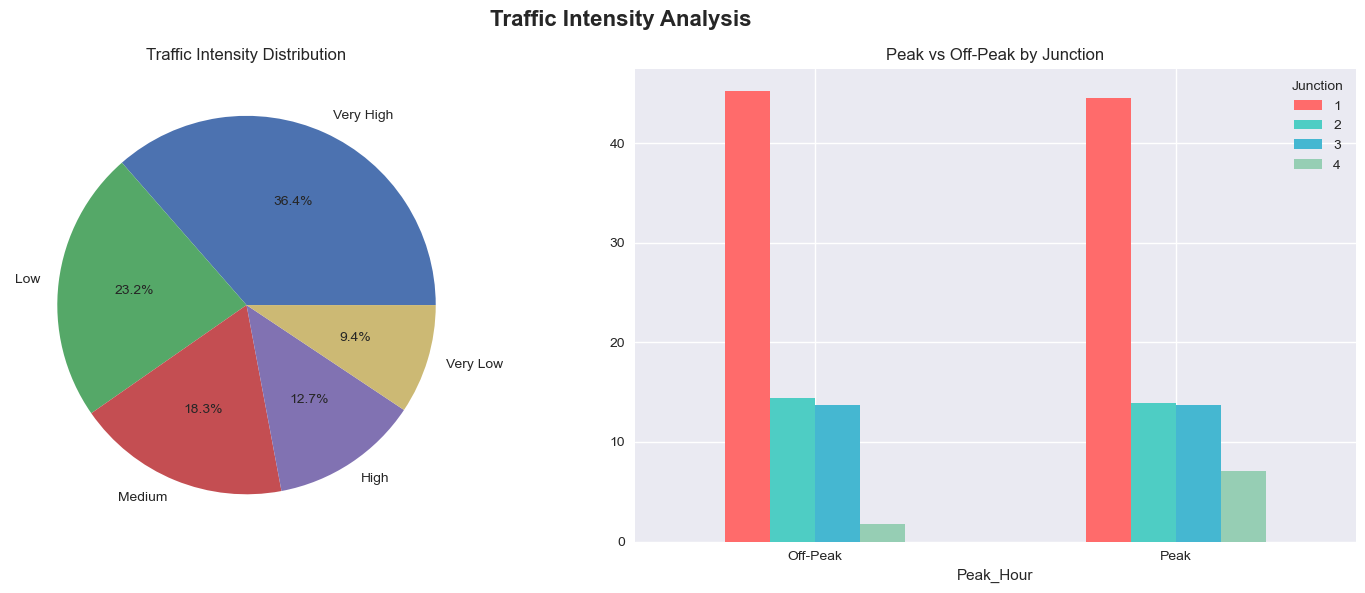

In [30]:
# Time-based Analysis
fig, axes = plt.subplots(2, 2, figsize=fig_size)
fig.suptitle('Time-based Traffic Analysis', fontsize=16, fontweight='bold')

# Hourly patterns
hourly = df_processed.groupby('Hour')['Vehicles_Sum'].mean()
axes[0,0].plot(hourly.index, hourly.values, 'o-', color='purple')
axes[0,0].set_title('Traffic by Hour')
axes[0,0].grid(True, alpha=0.3)

# Day patterns
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow = df_processed.groupby('DayName')['Vehicles_Sum'].mean().reindex(day_order)
axes[0,1].bar(range(len(dow)), dow.values, color='orange', alpha=0.7)
axes[0,1].set_title('Traffic by Day')
axes[0,1].set_xticklabels(day_order, rotation=45)

# Monthly patterns
monthly = df_processed.groupby('Month')['Vehicles_Sum'].mean()
axes[1,0].plot(monthly.index, monthly.values, 's-', color='red')
axes[1,0].set_title('Traffic by Month')
axes[1,0].grid(True, alpha=0.3)

# Weekend vs Weekday
weekend_comp = df_processed.groupby('Day_Type')['Vehicles_Sum'].mean()
axes[1,1].bar(weekend_comp.index, weekend_comp.values, color=['lightblue', 'lightgreen'])
axes[1,1].set_title('Weekend vs Weekday')

plt.tight_layout()
plt.show()

# Traffic Intensity Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Traffic Intensity Analysis', fontsize=16, fontweight='bold')

# Intensity pie chart
intensity = df_processed['Traffic_Intensity'].value_counts()
axes[0].pie(intensity.values, labels=intensity.index, autopct='%1.1f%%')
axes[0].set_title('Traffic Intensity Distribution')

# Peak analysis
peak_data = df_processed.groupby(['Peak_Hour', 'Junction'])['Vehicles_Sum'].mean().unstack()
peak_data.plot(kind='bar', ax=axes[1], color=colors[:4])
axes[1].set_title('Peak vs Off-Peak by Junction')
axes[1].set_xticklabels(['Off-Peak', 'Peak'], rotation=0)

plt.tight_layout()
plt.show()


## 6. Summary and Export

Final summary of the data processing pipeline and export options for the processed datasets.


In [31]:
# Pipeline Summary
print("📊 DATA PROCESSING SUMMARY")
print("=" * 40)

print("✅ COMPLETED:")
print(f"   • Loaded: {df.shape[0]:,} records")
print(f"   • Cleaned: {df_clean.shape[0]:,} records")  
print(f"   • Processed: {df_processed.shape[0]:,} records")

print("\n🔧 FEATURES ADDED:")
print("   • Multiple normalization methods")
print("   • Traffic intensity categories")
print("   • Peak/rush hour classification")
print("   • Time-based features")

print(f"\n📈 AGGREGATIONS:")
print(f"   • Hourly: {len(df_hourly):,} records")
print(f"   • Daily: {len(df_daily):,} records") 
print(f"   • Monthly: {len(df_monthly):,} records")

print(f"\n⚡ KEY INSIGHTS:")
total_vehicles = df_processed['Vehicles_Sum'].sum()
avg_vehicles = df_processed['Vehicles_Sum'].mean()
busiest_junction = df_processed.groupby('Junction')['Vehicles_Sum'].sum().idxmax()
busiest_hour = df_processed.groupby('Hour')['Vehicles_Sum'].mean().idxmax()
peak_ratio = df_processed[df_processed['Peak_Hour']]['Vehicles_Sum'].mean() / df_processed[~df_processed['Peak_Hour']]['Vehicles_Sum'].mean()

print(f"   • Total vehicles: {total_vehicles:,}")
print(f"   • Average/hour: {avg_vehicles:.0f}")
print(f"   • Busiest junction: {busiest_junction}")
print(f"   • Peak hour: {busiest_hour}:00")
print(f"   • Peak ratio: {peak_ratio:.1f}x")


📊 DATA PROCESSING SUMMARY
✅ COMPLETED:
   • Loaded: 48,120 records
   • Cleaned: 48,120 records
   • Processed: 58,368 records

🔧 FEATURES ADDED:
   • Multiple normalization methods
   • Traffic intensity categories
   • Peak/rush hour classification
   • Time-based features

📈 AGGREGATIONS:
   • Hourly: 58,368 records
   • Daily: 4,464 records
   • Monthly: 144 records

⚡ KEY INSIGHTS:
   • Total vehicles: 1,096,719
   • Average/hour: 19
   • Busiest junction: 1
   • Peak hour: 19.0:00
   • Peak ratio: 1.3x


In [33]:
# FINAL SUMMARY: Peak Traffic Hours & Busiest Days
print("🎯 TRAFFIC ANALYSIS SUMMARY")
print("=" * 40)

# Quick data prep if needed
if 'Hour' not in df.columns:
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')
    df['Hour'] = df['DateTime'].dt.hour
    df['DayName'] = df['DateTime'].dt.day_name()

# Peak Hours
hourly_avg = df.groupby('Hour')['Vehicles'].mean()
peak_hours = hourly_avg.nlargest(3)
quiet_hours = hourly_avg.nsmallest(3)

print(f"\n🕐 PEAK HOURS:")
for hour, vehicles in peak_hours.items():
    print(f"   {hour:02d}:00 - {vehicles:.0f} vehicles/hour")

print(f"\n📉 QUIETEST HOURS:")
for hour, vehicles in quiet_hours.items():
    print(f"   {hour:02d}:00 - {vehicles:.0f} vehicles/hour")

# Busiest Days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = df.groupby('DayName')['Vehicles'].mean().reindex(day_order)
dow_ranked = dow_avg.sort_values(ascending=False)

print(f"\n📅 BUSIEST DAYS:")
for i, (day, vehicles) in enumerate(dow_ranked.head(3).items(), 1):
    print(f"   {i}. {day}: {vehicles:.0f} vehicles/hour")

# Quick Summary
peak_ratio = peak_hours.max() / quiet_hours.min()
weekday_avg = dow_avg[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean()
weekend_avg = dow_avg[['Saturday', 'Sunday']].mean()
busiest_day = dow_ranked.index[0]  # Define the missing variable

print(f"\n⚡ KEY INSIGHTS:")
print(f"   • Peak vs Quiet: {peak_ratio:.1f}x difference")
print(f"   • Weekdays vs Weekends: {weekday_avg/weekend_avg:.1f}x busier")
print(f"   • Busiest: {busiest_day} at {peak_hours.idxmax():02d}:00")

print(f"\n" + "="*60)
print("🎯 SUMMARY FOR BUSINESS DECISIONS:")
print("="*60)
print(f"⏰ FOCUS ON THESE PEAK HOURS: {', '.join([f'{h:02d}:00' for h in peak_hours.head(3).index])}")
print(f"📅 BUSIEST DAYS: {busiest_day} > {dow_ranked.index[1]} > {dow_ranked.index[2]}")
print(f"💰 REVENUE OPPORTUNITY: {peak_ratio:.1f}x higher demand during peak vs quiet hours")
print(f"📊 WEEKDAY FOCUS: {weekday_avg / weekend_avg:.1f}x more traffic than weekends")
print("="*60)


🎯 TRAFFIC ANALYSIS SUMMARY

🕐 PEAK HOURS:
   19:00 - 30 vehicles/hour
   20:00 - 30 vehicles/hour
   12:00 - 28 vehicles/hour

📉 QUIETEST HOURS:
   05:00 - 12 vehicles/hour
   04:00 - 13 vehicles/hour
   06:00 - 13 vehicles/hour

📅 BUSIEST DAYS:
   1. Tuesday: 25 vehicles/hour
   2. Thursday: 25 vehicles/hour
   3. Wednesday: 25 vehicles/hour

⚡ KEY INSIGHTS:
   • Peak vs Quiet: 2.5x difference
   • Weekdays vs Weekends: 1.4x busier
   • Busiest: Tuesday at 19:00

🎯 SUMMARY FOR BUSINESS DECISIONS:
⏰ FOCUS ON THESE PEAK HOURS: 19:00, 20:00, 12:00
📅 BUSIEST DAYS: Tuesday > Thursday > Wednesday
💰 REVENUE OPPORTUNITY: 2.5x higher demand during peak vs quiet hours
📊 WEEKDAY FOCUS: 1.4x more traffic than weekends
